# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

## ПРОВЕРЯЮЩИЙ, вот [ТУТ](https://api.wandb.ai/links/belikoooova-hse/gk6bzxws) красивый и классный отчет, на котором все видно куда лучше, чем в коллабе

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-15 08:23:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [              <=>   ] 201.24M  2.07MB/s    in 39s     

2024-10-15 08:23:53 (5.10 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [ ]:
set_random_seed(42)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

In [ ]:
ridge_model = Ridge()

ridge_model.fit(X_train_scaled, y_train)
y_pred = ridge_model.predict(X_test_scaled)

rmse_for_model = root_mean_squared_error(y_test, y_pred)

rmse_for_model

9.510160820470436

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
y_pred_constant = np.full_like(y_test, np.mean(y_train))

best_rmse_metric = root_mean_squared_error(y_test, y_pred_constant)

best_rmse_metric

10.863228020678134

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
!pip install wandb --upgrade --quiet

import wandb

wandb.login()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
class TinyModel(nn.Module):
    def __init__(self, input_shape=90):
        super(TinyModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, 1)
        )

    def forward(self, X):
       return self.model(X)

In [ ]:
def train_loop(model, train_loader, validation_loader, optimizer, loss_function, metric_function, n_epoch=10):
    model.to(device)

    train_loss_history = []
    val_loss_history = []
    train_metric_history = []
    val_metric_history = []

    for i in range(n_epoch):
        model.train()
        train_loss_batches = []
        train_metric_batches = []

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            out = model.forward(X_batch)
            loss = loss_function(y_batch, out)
            metric = metric_function(y_batch, out)

            loss.backward()
            optimizer.step()

            train_loss_batches.append(loss.item())
            train_metric_batches.append(metric.item())

        train_loss_history.append(np.mean(train_loss_batches))
        train_metric_history.append(np.mean(train_metric_batches))


        model.eval()
        val_loss_batches = []
        val_metric_batches = []

        with torch.no_grad():
          for X_batch, y_batch in validation_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            out = model.forward(X_batch)
            loss = loss_function(y_batch, out)
            metric = metric_function(y_batch, out)

            val_loss_batches.append(loss.item())
            val_metric_batches.append(metric.item())

        val_loss_history.append(np.mean(val_loss_batches))
        val_metric_history.append(np.mean(val_metric_batches))

        wandb.log(
            {
                "mean val loss": np.mean(val_loss_batches),
                "mean train loss": np.mean(train_loss_batches),
                "mean val metric": np.mean(val_metric_batches),
                "mean train metric": np.mean(train_metric_batches),
            }
        )

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.set_xlabel("#epoch")
        ax1.set_ylabel("Loss")
        ax1.plot(train_loss_history, 'b', label='train loss')
        ax1.plot(val_loss_history, 'r', label='val loss')
        ax1.legend()

        ax2.set_xlabel("#epoch")
        ax2.set_ylabel("RMSE")
        ax2.plot(train_metric_history, 'g', label='train RMSE')
        ax2.plot(val_metric_history, 'pink', label='val RMSE')
        ax2.legend()

        plt.show()

In [ ]:
class CustomSGD:
    def __init__(self, model, lr=1e-4):
        self.model = model
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.model.parameters():
                param -= self.lr * param.grad

    def zero_grad(self):
        with torch.no_grad():
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), self.y[idx]

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_data = CustomDataset(X_train_scaled, y_train)
test_data = CustomDataset(X_test_scaled, y_test)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

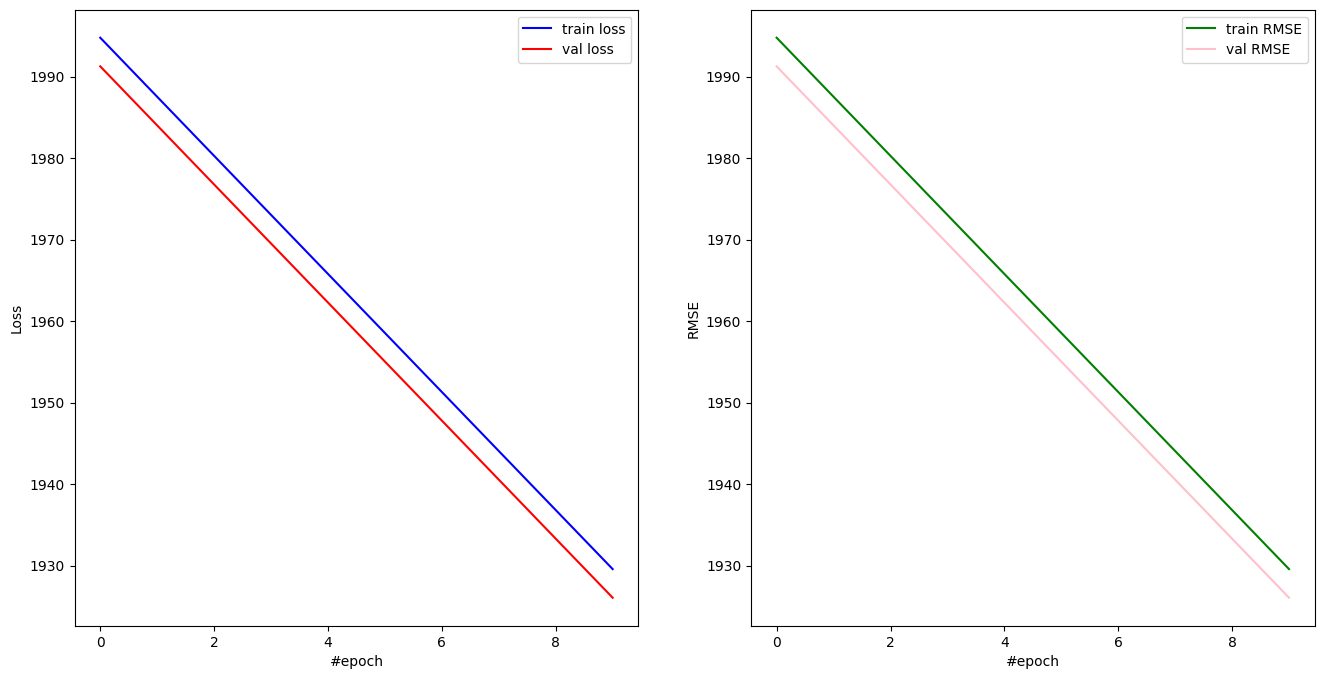

In [ ]:
set_random_seed(42)

tiny_model = TinyModel()
tiny_optimizer = CustomSGD(tiny_model, lr=1e-3)
tiny_loss_function = lambda true, pred: torch.sqrt(torch.mean((true - pred) ** 2))
tiny_metric_function = lambda true, pred: torch.sqrt(torch.mean((true - pred) ** 2))

wandb.init(project="ida-bodl-hw1", name="tiny_model")
wandb.watch(tiny_model);

train_loop(tiny_model, train_dataloader, test_dataloader, tiny_optimizer, tiny_loss_function, tiny_metric_function)

Пока что loss и metric - одно и то же, но заложила в код функции, что это могут быть две разные вещи)

Ну и, конечно, качество - тильт... Пока что)

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,2002.000000,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,2006.000000,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


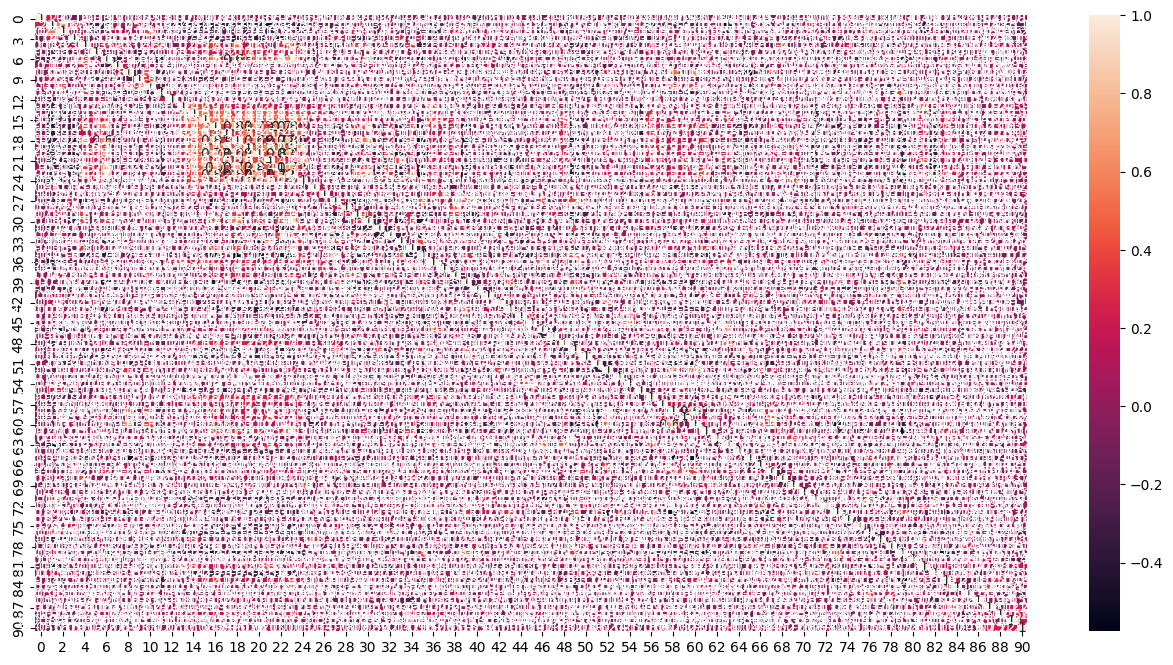

In [ ]:
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

mp.figure(figsize=(16, 8))

dataplot = sb.heatmap(df.corr(numeric_only=True), annot=True)

mp.show()

  Так себе идея) Но пусть останется

In [ ]:
scaler_y = StandardScaler()

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [ ]:
train_set = CustomDataset(X_train_scaled, y_train_scaled)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = CustomDataset(X_test_scaled, y_test_scaled)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
class AdvancedModel(nn.Module):
    def __init__(self, input_shape=90, hidden_size=128):
        super(AdvancedModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, X):
       return self.model(X)

In [ ]:
import torch.nn.functional as F

In [ ]:
def train(model, train_loader, optimizer, loss_function, metric_function, scaler):
    model.train()
    train_loss_batches = []
    train_metric_batches = []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        optimizer.zero_grad()
        out = model.forward(X_batch)
        loss = loss_function(y_batch, out)

        loss.backward()
        optimizer.step()

        if scaler is not None:
            with torch.no_grad():
                out_scaled = scaler.inverse_transform(out.cpu().numpy())
                out_scaled = torch.from_numpy(out_scaled).to(device).float()

                y_batch_scaled = scaler.inverse_transform(y_batch.cpu().numpy())
                y_batch_scaled = torch.from_numpy(y_batch_scaled).to(device).float()

            metric = metric_function(y_batch_scaled, out_scaled)
        else:
            metric = metric_function(y_batch, out)

        train_loss_batches.append(loss.item())
        train_metric_batches.append(metric.item())

    train_loss = np.mean(train_loss_batches)
    train_metric = np.mean(train_metric_batches)

    return train_loss, train_metric


def test(model, validation_loader, loss_function, metric_function, scaler):
    model.eval()
    val_loss_batches = []
    val_metric_batches = []

    with torch.no_grad():
        for X_batch, y_batch in validation_loader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).float()

            out = model.forward(X_batch)
            loss = loss_function(y_batch, out)

            if scaler is not None:
                with torch.no_grad():
                    out_scaled = scaler.inverse_transform(out.cpu().numpy())
                    out_scaled = torch.from_numpy(out_scaled).to(device).float()

                    y_batch_scaled = scaler.inverse_transform(y_batch.cpu().numpy())
                    y_batch_scaled = torch.from_numpy(y_batch_scaled).to(device).float()

                metric = metric_function(y_batch_scaled, out_scaled)
            else:
                metric = metric_function(y_batch, out)

            val_loss_batches.append(loss.item())
            val_metric_batches.append(metric.item())

    val_loss = np.mean(val_loss_batches)
    val_metric = np.mean(val_metric_batches)

    return val_loss, val_metric

In [ ]:
def train_loop(model, train_loader, validation_loader, optimizer, loss_function, metric_function, scaler=None, n_epoch=10):
    model.to(device)

    train_loss_history = []
    val_loss_history = []
    train_metric_history = []
    val_metric_history = []

    for i in range(n_epoch):
        train_loss, train_metric = train(model, train_loader, optimizer, loss_function, metric_function, scaler)
        train_loss_history.append(train_loss)
        train_metric_history.append(train_metric)

        val_loss, val_metric = test(model, validation_loader, loss_function, metric_function, scaler)
        val_loss_history.append(val_loss)
        val_metric_history.append(val_metric)

        wandb.log(
            {
                "mean val loss": val_loss,
                "mean train loss": train_loss,
                "mean val metric": val_metric,
                "mean train metric": train_metric,
            }
        )

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        ax1.set_xlabel("#epoch")
        ax1.set_ylabel("Loss")
        ax1.plot(train_loss_history, 'b', label='train loss')
        ax1.plot(val_loss_history, 'r', label='val loss')
        ax1.legend()

        ax2.set_xlabel("#epoch")
        ax2.set_ylabel("RMSE")
        ax2.plot(train_metric_history, 'g', label='train RMSE')
        ax2.plot(val_metric_history, 'pink', label='val RMSE')
        ax2.legend()

        plt.legend()
        plt.show()

    print(f'Final train RMSE: {train_metric_history[-1]}')
    print(f'Final test RMSE: {val_metric_history[-1]}')

- Удалила ячейку с ассертом, так как у меня другая сигнатура
- Я постаралась по максимуму переиспользовать функцию из предыдущего задания, она очень подробная и классная кмк

### 1 модель
#### Final train RMSE: 8.731626832810944
#### Final test RMSE: 8.080182025571442

- nn.Linear(90, 64) -> nn.ReLU() -> nn.Linear(64, 1)
- lr = 1e-4
- optimizer - Adam


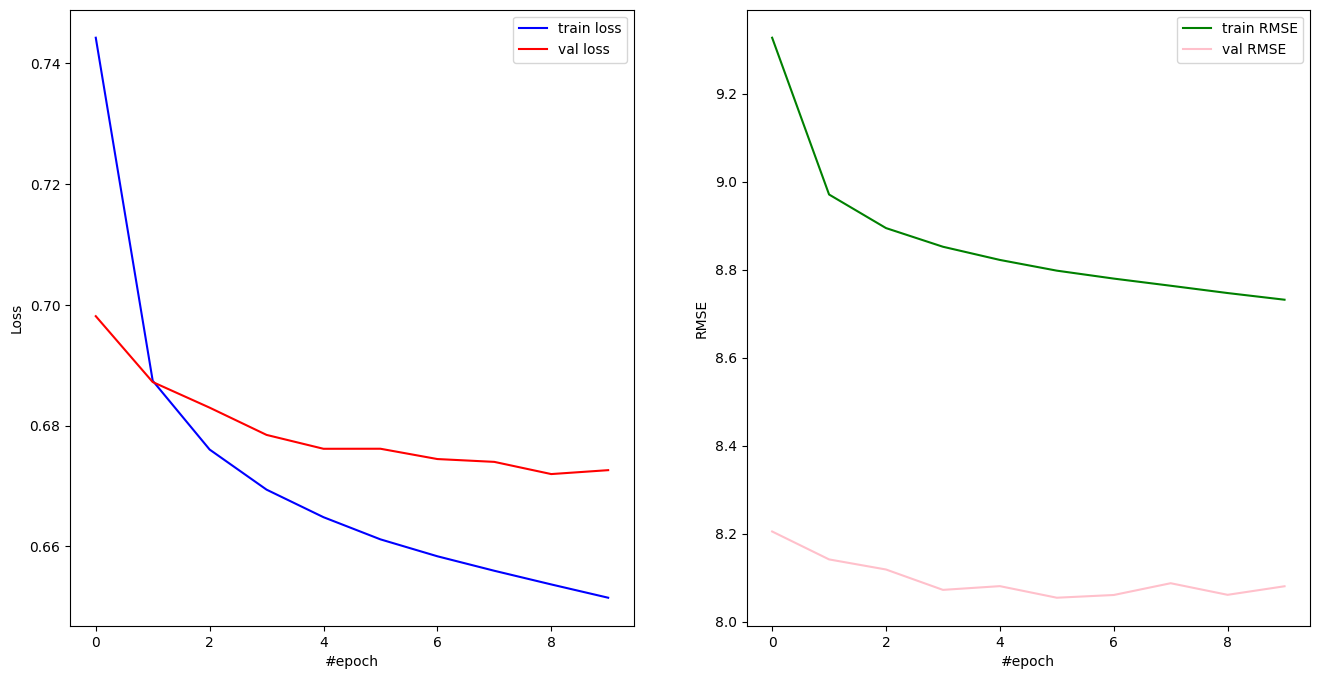

Final train RMSE: 8.731626832810944
Final test RMSE: 8.080182025571442


In [ ]:
set_random_seed(42)

model = AdvancedModel(hidden_size=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = F.mse_loss
metric_function = lambda true, pred: torch.sqrt(torch.mean((true - pred) ** 2))

wandb.init(project="ida-bodl-hw1", name="advanced_model_pivot")
wandb.watch(model);

train_loop(model, train_loader, test_loader, optimizer, loss_function, metric_function, scaler_y)

### 2 модель
#### Final train RMSE: 8.668231574007729
#### Final test RMSE: 8.061893811456333
- nn.Linear(90, 128) -> nn.ReLU() -> nn.Linear(128, 1)
- lr = 1e-4
- optimizer - Adam


In [ ]:
class LargerAdvancedModel(nn.Module):
    def __init__(self, input_shape=90, hidden_size=128):
        super(LargerAdvancedModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, X):
       return self.model(X)

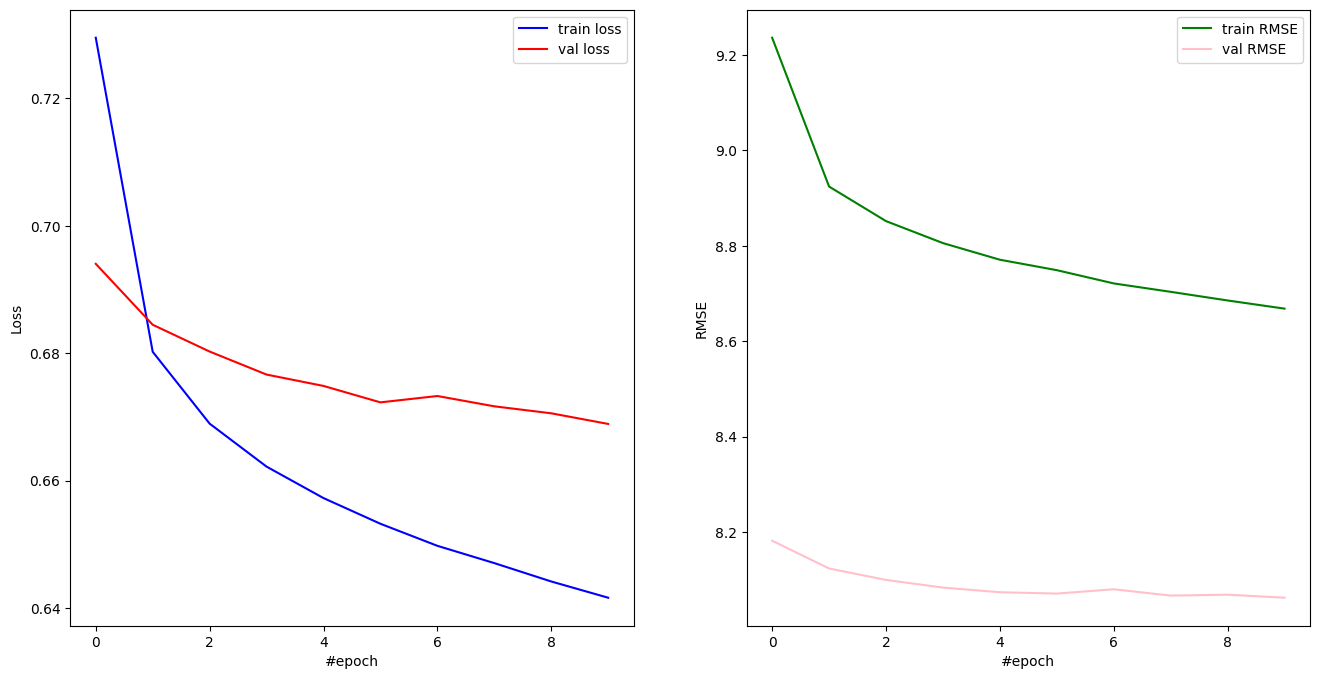

Final train RMSE: 8.668231574007729
Final test RMSE: 8.061893811456333


In [ ]:
set_random_seed(42)

model = LargerAdvancedModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = F.mse_loss
metric_function = lambda true, pred: torch.sqrt(torch.mean((true - pred) ** 2))

wandb.init(project="ida-bodl-hw1", name="advanced_model_larger_hidden_size")
wandb.watch(model);

train_loop(model, train_loader, test_loader, optimizer, loss_function, metric_function, scaler_y)

### 3 модель
#### Final train RMSE: 8.759691754987877
#### Final test RMSE: 8.069890962657432
- nn.Linear(90, 128) -> nn.BatchNorm1d(128) -> nn.ReLU() -> nn.Linear(128, 1)
- lr = 1e-4
- optimizer - Adam

In [ ]:
class LargerAdvancedModelBatchNorm(nn.Module):
    def __init__(self, input_shape=90, hidden_size=128):
        super(LargerAdvancedModelBatchNorm, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, X):
       return self.model(X)

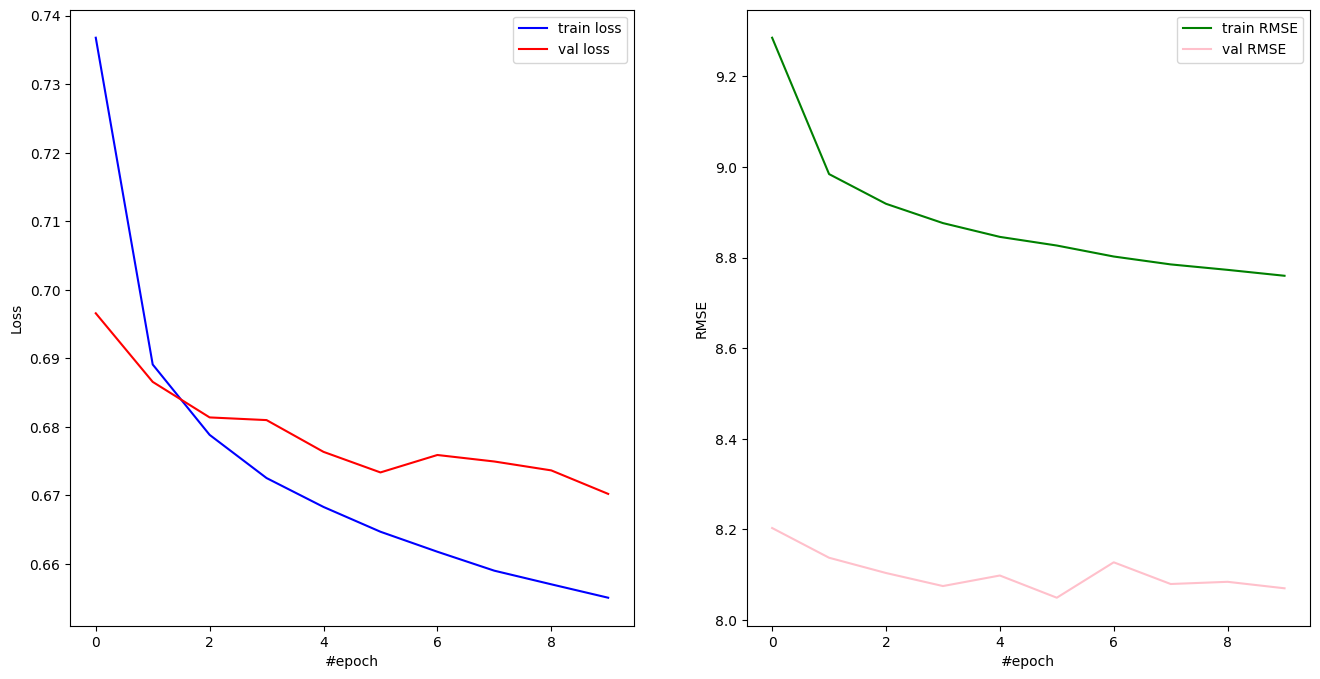

Final train RMSE: 8.759691754987877
Final test RMSE: 8.069890962657432


In [ ]:
set_random_seed(42)

model = LargerAdvancedModelBatchNorm()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = F.mse_loss
metric_function = lambda true, pred: torch.sqrt(torch.mean((true - pred) ** 2))

wandb.init(project="ida-bodl-hw1", name="advanced_model_larger_hidden_size_and_batchnorm")
wandb.watch(model);

train_loop(model, train_loader, test_loader, optimizer, loss_function, metric_function, scaler_y)

### 4 модель
#### Final train RMSE: 8.628499286726894
#### Final test RMSE: 7.985280305184101
- nn.Linear(90, 128) -> nn.BatchNorm1d(128) -> nn.ReLU() -> nn.Linear(128, 1)
- lr = 1e-3
- optimizer - Adam

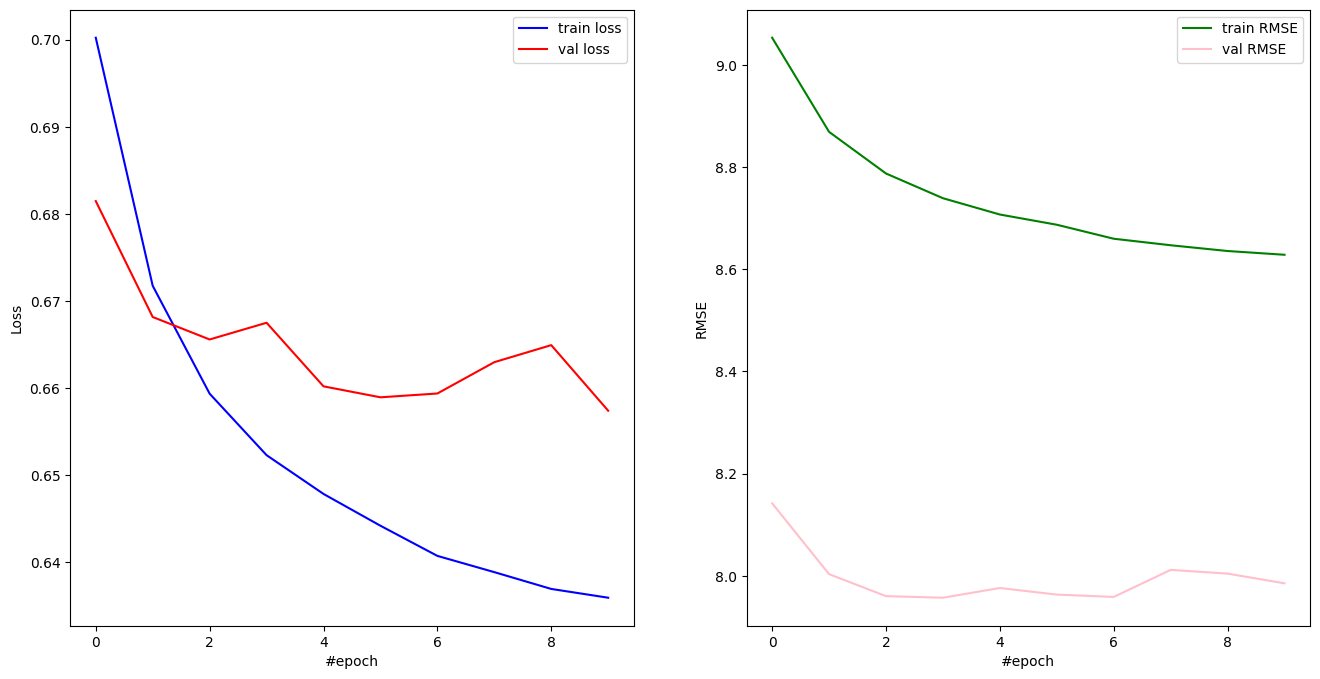

Final train RMSE: 8.628499286726894
Final test RMSE: 7.985280305184101


In [ ]:
set_random_seed(42)

model = LargerAdvancedModelBatchNorm()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = F.mse_loss
metric_function = lambda true, pred: torch.sqrt(torch.mean((true - pred) ** 2))

wandb.init(project="ida-bodl-hw1", name="advanced_model_larger_hidden_size_and_batchnorm_and_larger_lr")
wandb.watch(model);

train_loop(model, train_loader, test_loader, optimizer, loss_function, metric_function, scaler_y)

### 5 модель
#### Final train RMSE: 8.940652961794132
#### Final test RMSE: 8.18330527090524
- nn.Linear(90, 128) -> nn.Dropout(0.5) -> nn.BatchNorm1d(128) -> nn.ReLU() -> nn.Linear(128, 1)
- lr = 1e-3
- optimizer - Adam

In [ ]:
class LargerAdvancedModelBatchNormDropout(nn.Module):
    def __init__(self, input_shape=90, hidden_size=128, dropout_prob=0.5):
        super(LargerAdvancedModelBatchNormDropout, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_size),
            nn.Dropout(dropout_prob),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, X):
       return self.model(X)

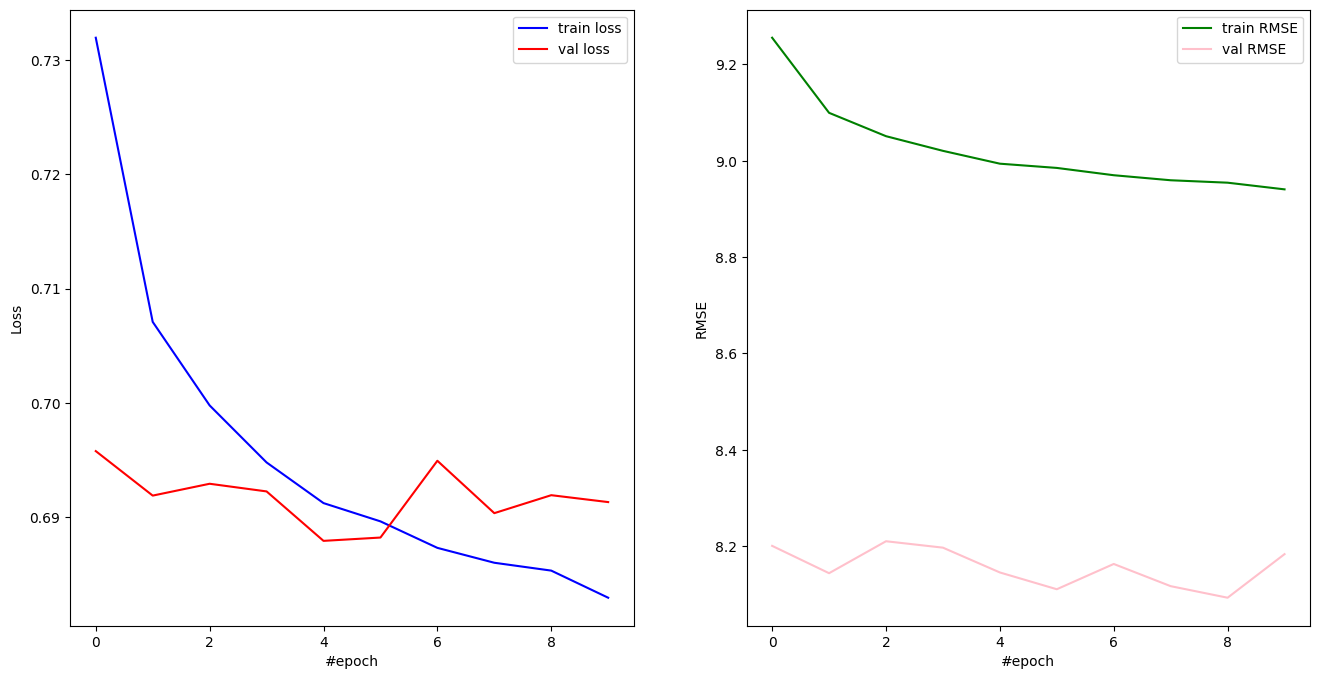

Final train RMSE: 8.940652961794132
Final test RMSE: 8.18330527090524


In [ ]:
set_random_seed(42)

model = LargerAdvancedModelBatchNormDropout()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = F.mse_loss
metric_function = lambda true, pred: torch.sqrt(torch.mean((true - pred) ** 2))

wandb.init(project="ida-bodl-hw1", name="advanced_model_larger_hidden_size_and_batchnorm_and_larger_lr_and_longer_and_dropout")
wandb.watch(model);

train_loop(model, train_loader, test_loader, optimizer, loss_function, metric_function, scaler_y)

### 6 модель
#### Final train RMSE: 8.367648370615395
#### Final test RMSE: 7.8906123141817
- nn.Linear(90, 128) -> nn.BatchNorm1d(128) -> nn.ReLU() -> nn.Linear(128, 64) -> nn.BatchNorm1d(64) -> nn.ReLU() -> nn.Linear(64, 1)
- lr = 1e-3
- optimizer - Adam




In [ ]:
class LargerAdvancedModelBatchNormMoreLinearLayer(nn.Module):
    def __init__(self, input_shape=90, hidden_size_1=128, hidden_size_2=64, dropout_prob=0.5):
        super(LargerAdvancedModelBatchNormMoreLinearLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_size_1),
            nn.BatchNorm1d(hidden_size_1),
            nn.ReLU(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.BatchNorm1d(hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, 1)
        )

    def forward(self, X):
       return self.model(X)

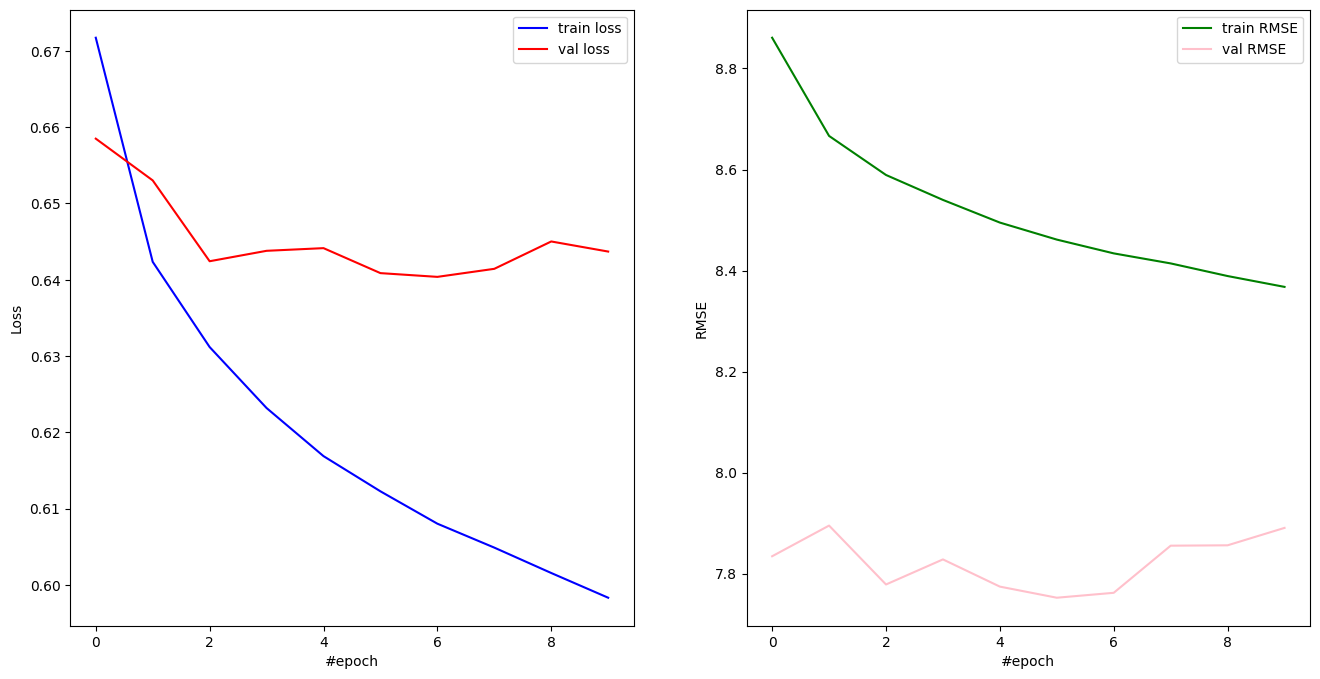

Final train RMSE: 8.367648370615395
Final test RMSE: 7.8906123141817


In [ ]:
set_random_seed(42)

model = LargerAdvancedModelBatchNormMoreLinearLayer()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = F.mse_loss
metric_function = lambda true, pred: torch.sqrt(torch.mean((true - pred) ** 2))

wandb.init(project="ida-bodl-hw1", name="advanced_model_larger_hidden_size_and_batchnorm_and_larger_lr_and_longer_and_more_ll")
wandb.watch(model);

train_loop(model, train_loader, test_loader, optimizer, loss_function, metric_function, scaler_y)

### 7 модель
#### Final train RMSE: 8.722430136728248
#### Final test RMSE: 7.828335686982638
- nn.Linear(90, 128) -> nn.BatchNorm1d(128) -> nn.Dropout(0.5) -> nn.ReLU() -> nn.Linear(128, 64) -> nn.BatchNorm1d(64) -> nn.ReLU() -> nn.Linear(64, 1)
- lr = 1e-3
- optimizer - Adam




In [ ]:
class LargerAdvancedModelBatchNormMoreLinearLayerDropout(nn.Module):
    def __init__(self, input_shape=90, hidden_size_1=128, hidden_size_2=64, dropout_prob=0.5):
        super(LargerAdvancedModelBatchNormMoreLinearLayerDropout, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_size_1),
            nn.BatchNorm1d(hidden_size_1),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.BatchNorm1d(hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, 1)
        )

    def forward(self, X):
       return self.model(X)

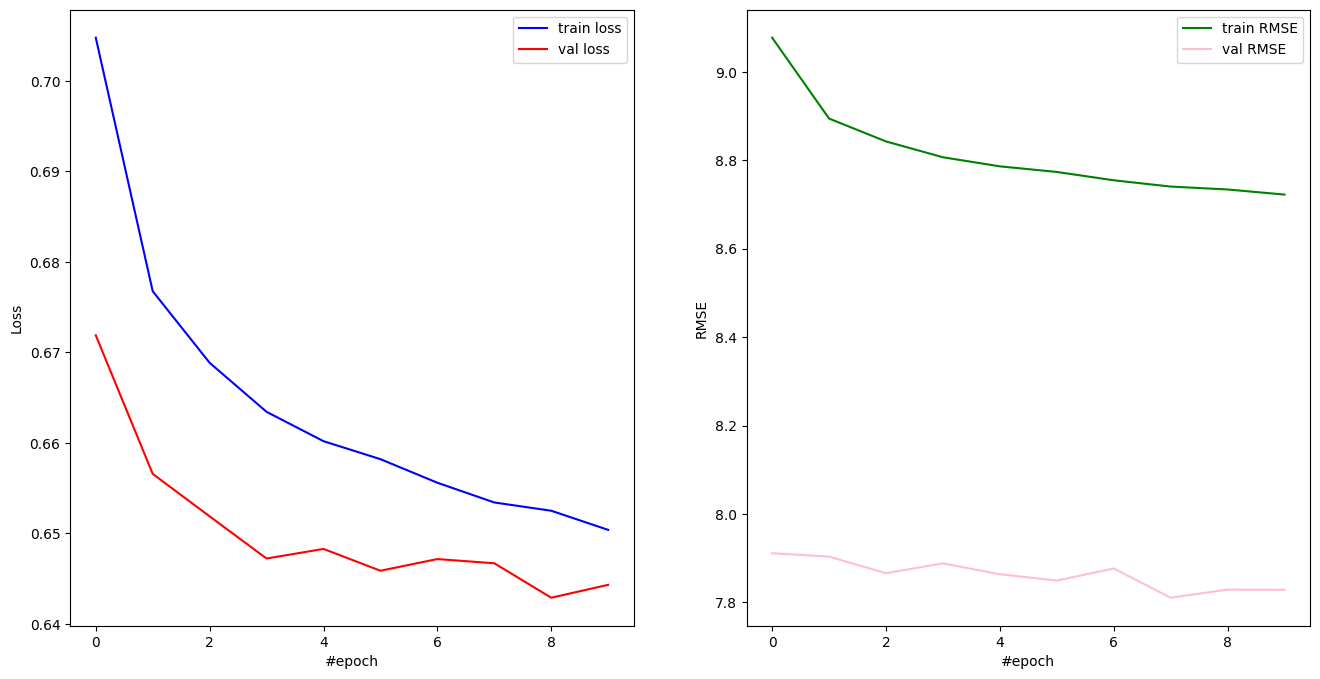

Final train RMSE: 8.722430136728248
Final test RMSE: 7.828335686982638


In [ ]:
set_random_seed(42)

model = LargerAdvancedModelBatchNormMoreLinearLayerDropout()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = F.mse_loss
metric_function = lambda true, pred: torch.sqrt(torch.mean((true - pred) ** 2))

wandb.init(project="ida-bodl-hw1", name="advanced_model_larger_hidden_size_and_batchnorm_and_larger_lr_and_longer_and_more_ll_and_dropout")
wandb.watch(model);

train_loop(model, train_loader, test_loader, optimizer, loss_function, metric_function, scaler_y)

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

## Поехали

### 1 модель
#### Final train RMSE: 8.731626832810944
#### Final test RMSE: 8.080182025571442

- nn.Linear(90, 64) -> nn.ReLU() -> nn.Linear(64, 1)
- lr = 1e-4
- optimizer - Adam

Простая моделька с параметрами, которые первые пришли в голову. Надо же было с чего-то начать) Неожиданно, но нужный скор выбился с первого раза)

Не очень поняла, почему у меня сразу на валидации качество лучше, чем на трейне, хотя до дропаута еще далеко...

### 2 модель
#### Final train RMSE: 8.668231574007729
#### Final test RMSE: 8.061893811456333
- nn.Linear(90, 128) -> nn.ReLU() -> nn.Linear(128, 1)
- lr = 1e-4
- optimizer - Adam

Первым шагом к оптимизации стало увеличние размера hidden слоя. В итоге улучшилось на 0.02 метрики.

### 3 модель
#### Final train RMSE: 8.759691754987877
#### Final test RMSE: 8.069890962657432
- nn.Linear(90, 128) -> nn.BatchNorm1d(128) -> nn.ReLU() -> nn.Linear(128, 1)
- lr = 1e-4
- optimizer - Adam

Решила добавить батчнорм, но никаких значимых изменений не заметила. Вероятно потому, что особого переобучения и не было.

### 4 модель
#### Final train RMSE: 8.628499286726894
#### Final test RMSE: 7.985280305184101
- nn.Linear(90, 128) -> nn.BatchNorm1d(128) -> nn.ReLU() -> nn.Linear(128, 1)
- lr = 1e-3
- optimizer - Adam

Было предположение, что моделька учится очень медленно - поэтому увеличила lr в 10 раз. И не пожалела - прирост качества на 0.08!

### 5 модель
#### Final train RMSE: 8.940652961794132
#### Final test RMSE: 8.18330527090524
- nn.Linear(90, 128) -> nn.Dropout(0.5) -> nn.BatchNorm1d(128) -> nn.ReLU() -> nn.Linear(128, 1)
- lr = 1e-3
- optimizer - Adam

Попробовала дропаут - стало сильно хуже) Он попытался вылечить переобучение, которого не было)

### 6 модель
#### Final train RMSE: 8.367648370615395
#### Final test RMSE: 7.8906123141817
- nn.Linear(90, 128) -> nn.BatchNorm1d(128) -> nn.ReLU() -> nn.Linear(128, 64) -> nn.BatchNorm1d(64) -> nn.ReLU() -> nn.Linear(64, 1)
- lr = 1e-3
- optimizer - Adam

Добавила еще один линейный слой - и не зря, прирост на 0.09!

### 7 модель
#### Final train RMSE: 8.722430136728248
#### Final test RMSE: 7.828335686982638
- nn.Linear(90, 128) -> nn.BatchNorm1d(128) -> nn.Dropout(0.5) -> nn.ReLU() -> nn.Linear(128, 64) -> nn.BatchNorm1d(64) -> nn.ReLU() -> nn.Linear(64, 1)
- lr = 1e-3
- optimizer - Adam

Вот теперь график на предыдущей модели был слишком ломаный - переобучаемся. Добавила дропаут с вероятностью 0.5 - прирост на 0.07)


## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder

In [ ]:
def prepare_classification_data(df, binning=False, n_bins=10):
    X = df.iloc[:, 1:].values
    y = df.iloc[:, 0].values

    if binning:
        binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
        y = binner.fit_transform(y.reshape(-1, 1)).astype(int).flatten()
        n_classes = n_bins
    else:
        encoder = LabelEncoder()
        y = encoder.fit_transform(y)
        n_classes = len(np.unique(y))

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.int)

    train_size = 463715
    X_train = X[:train_size, :]
    y_train = y[:train_size]
    X_test = X[train_size:, :]
    y_test = y[train_size:]

    return X_train, y_train, X_test, y_test, n_classes

In [ ]:
def train_cl(model, train_loader, optimizer, loss_function, metric_functions):
    model.train()
    train_loss_batches = []
    train_metric_batches = [[] for _ in range(len(metric_functions))]
    idx = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).long()
        y_batch = y_batch.view(-1)

        optimizer.zero_grad()
        out = model.forward(X_batch)
        loss = loss_function(out, y_batch)

        loss.backward()
        optimizer.step()

        pred_classes = torch.argmax(out, dim=1).cpu().numpy()
        true_classes = y_batch.cpu().numpy()

        for idx, mf in enumerate(metric_functions):
            train_metric_batches[idx].append(mf(true_classes, pred_classes))

        train_loss_batches.append(loss.item())

    train_loss = np.mean(train_loss_batches)
    train_metrics = [np.mean(metrics) for metrics in train_metric_batches]

    return train_loss, train_metrics


def test_cl(model, validation_loader, loss_function, metric_functions):
    model.eval()
    val_loss_batches = []
    val_metric_batches = [[] for _ in range(len(metric_functions))]

    with torch.no_grad():
        for X_batch, y_batch in validation_loader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).long()
            y_batch = y_batch.view(-1)

            out = model.forward(X_batch)
            loss = loss_function(out, y_batch)

            pred_classes = torch.argmax(out, dim=1).cpu().numpy()
            true_classes = y_batch.cpu().numpy()

            for idx, mf in enumerate(metric_functions):
                val_metric_batches[idx].append(mf(true_classes, pred_classes))

            val_loss_batches.append(loss.item())

    val_loss = np.mean(val_loss_batches)
    val_metrics = [np.mean(metrics) for metrics in val_metric_batches]

    return val_loss, val_metrics

In [ ]:
def train_loop_cl(model, train_loader, validation_loader, optimizer, loss_function, metric_functions_dict, scaler=None, n_epoch=10):
    model.to(device)

    train_loss_history = []
    val_loss_history = []
    train_metric_history = {name: [] for name in metric_functions_dict.keys()}
    val_metric_history = {name: [] for name in metric_functions_dict.keys()}

    for i in range(n_epoch):
        train_loss, train_metrics = train_cl(model, train_loader, optimizer, loss_function, list(metric_functions_dict.values()))
        train_loss_history.append(train_loss)
        for idx, (name, _) in enumerate(metric_functions_dict.items()):
            train_metric_history[name].append(train_metrics[idx])

        val_loss, val_metrics = test_cl(model, validation_loader, loss_function, list(metric_functions_dict.values()))
        val_loss_history.append(val_loss)
        for idx, (name, _) in enumerate(metric_functions_dict.items()):
            val_metric_history[name].append(val_metrics[idx])

        log_data = {
            "classification mean val loss": val_loss,
            "classification mean train loss": train_loss,
        }


        for name, metrics in train_metric_history.items():
            log_data[f"classification mean train {name}"] = train_metric_history[name][-1]
        for name, metrics in val_metric_history.items():
            log_data[f"classification mean val {name}"] = val_metric_history[name][-1]

        wandb.log(log_data)

        clear_output(wait=True)
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        axes[0, 0].set_xlabel("#epoch")
        axes[0, 0].set_ylabel("Loss")
        axes[0, 0].plot(train_loss_history, 'b', label='train loss')
        axes[0, 0].plot(val_loss_history, 'r', label='val loss')
        axes[0, 0].legend()

        for idx, (name, _) in enumerate(metric_functions_dict.items()):
            row, col = divmod(idx + 1, 2)
            axes[row, col % 2].set_xlabel("#epoch")
            axes[row, col % 2].set_ylabel(name)
            axes[row, col % 2].plot(train_metric_history[name], 'b', label=f'train {name}')
            axes[row, col % 2].plot(val_metric_history[name], 'r', label=f'val {name}')
            axes[row, col % 2].legend()

        plt.show()

    print(f'Final train metrics: {train_metric_history}')
    print(f'Final test metrics: {val_metric_history}')

In [ ]:
set_random_seed(42)

X_train_cl_10, y_train_cl_10, X_test_cl_10, y_test_cl_10, n_classes = prepare_classification_data(df, binning=True)

scaler = StandardScaler()
X_train_cl_10_scaled = scaler.fit_transform(X_train_cl_10)
X_test_cl_10_scaled = scaler.transform(X_test_cl_10)

train_data_cl_10 = CustomDataset(X_train_cl_10_scaled, y_train_cl_10)
test_data_cl_10 = CustomDataset(X_test_cl_10_scaled, y_test_cl_10)

train_dataloader_cl_10 = DataLoader(train_data_cl_10, batch_size=64, shuffle=True)
test_dataloader_cl_10 = DataLoader(test_data_cl_10, batch_size=64, shuffle=True)

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self, output_shape, input_shape=90, hidden_size=128):
        super(ClassificationModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_shape)
        )

    def forward(self, X):
       return self.model(X)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

### 1 модель
#### Final train accuracy: 0.6007924938882536
#### Final test accuracy: 0.5942837131620063
#### Final train recall: 0.3415075791730961
#### Final test recall: 0.33633339935365436
#### Final train precision: 0.39012119472126816
#### Final test precision: 0.386009169132917

- nn.Linear(90, 64) -> nn.ReLU() -> nn.Linear(64, 1)
- lr = 1e-4

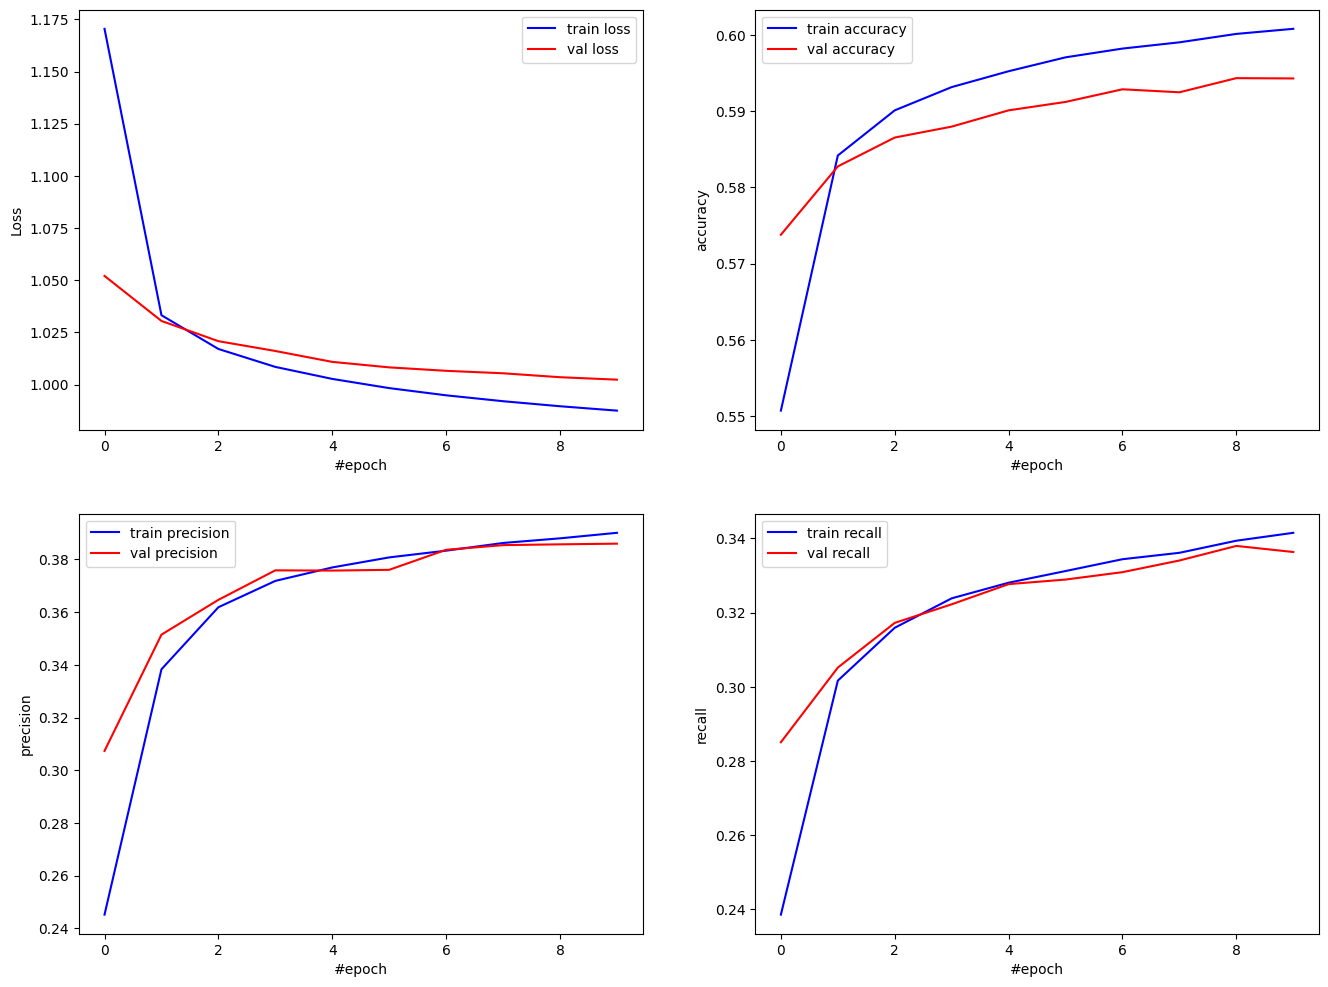

Final train metrics: {'accuracy': [0.5507117227238674, 0.5841740886597532, 0.590097985095225, 0.5931478204723789, 0.5952287099286306, 0.5970512055912621, 0.5982001153345688, 0.5990200258270574, 0.6001243912897757, 0.6007924938882536], 'precision': [0.2452054335653306, 0.3383244822877308, 0.3618748198844433, 0.37186823805226843, 0.3769782349834913, 0.3807900005984763, 0.3833422416501905, 0.386261755293013, 0.3880247201946196, 0.39012119472126816], 'recall': [0.2385691657741304, 0.3016563757872497, 0.3159105130520796, 0.3238437651530259, 0.3280557178932937, 0.3312021259912865, 0.33438904033342287, 0.3361167922208148, 0.3393774477543847, 0.3415075791730961]}
Final test metrics: {'accuracy': [0.5737828982813427, 0.5827440601260708, 0.5865314032110339, 0.5879641789235495, 0.5900981897527072, 0.5912009724691557, 0.592859355638166, 0.5924679098647702, 0.5943215950110446, 0.5942837131620063], 'precision': [0.3073412478377296, 0.35147027270581416, 0.36468026915859514, 0.37587507307428625, 0.375

classification mean train accuracy,▁▆▇▇▇▇████
classification mean train loss,█▃▂▂▂▁▁▁▁▁
classification mean train precision,▁▅▇▇▇█████
classification mean train recall,▁▅▆▇▇▇████
classification mean val accuracy,▁▄▅▆▇▇█▇██
classification mean val loss,█▅▄▃▂▂▂▁▁▁
classification mean val precision,▁▅▆▇▇▇████
classification mean val recall,▁▄▅▆▇▇▇▇██
classification mean train accuracy,0.60079
classification mean train loss,0.98756
classification mean train precision,0.39012


In [ ]:
set_random_seed(42)

model = ClassificationModel(output_shape=n_classes, hidden_size=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.CrossEntropyLoss()
metric_functions = {"accuracy": accuracy_score,
                    "precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro', zero_division=0),
                    "recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro', zero_division=0),}

wandb.init(project="ida-bodl-hw1", name="10_cl_classification_model_pivot")
wandb.watch(model);

train_loop_cl(model, train_dataloader_cl_10, test_dataloader_cl_10, optimizer, loss_function, metric_functions)

wandb.finish()

### 2 модель
#### Final train accuracy: 0.5925411433894563
#### Final test accuracy: 0.6018659757017403
#### Final train recall: 0.3387335340327869
#### Final test recall: 0.3596289142597895
#### Final train precision: 0.3818283842013166
#### Final test precision: 0.39980384388525997

- nn.Linear(90, 128) -> nn.BatchNorm1d(128) -> nn.Dropout(0.5) -> nn.ReLU() -> nn.Linear(128, 64) -> nn.BatchNorm1d(64) -> nn.ReLU() -> nn.Linear(64, 1)
- lr = 1e-3

In [ ]:
set_random_seed(42)

X_train_cl_10, y_train_cl_10, X_test_cl_10, y_test_cl_10, n_classes = prepare_classification_data(df, binning=True)

scaler = StandardScaler()
X_train_cl_10_scaled = scaler.fit_transform(X_train_cl_10)
X_test_cl_10_scaled = scaler.transform(X_test_cl_10)

train_data_cl_10 = CustomDataset(X_train_cl_10_scaled, y_train_cl_10)
test_data_cl_10 = CustomDataset(X_test_cl_10_scaled, y_test_cl_10)

train_dataloader_cl_10 = DataLoader(train_data_cl_10, batch_size=64, shuffle=True)
test_dataloader_cl_10 = DataLoader(test_data_cl_10, batch_size=64, shuffle=True)

In [ ]:
class AdvancedClassificationModel(nn.Module):
    def __init__(self, output_shape, input_shape=90, hidden_size_1=128, hidden_size_2=64, dropout_prob=0.5):
        super(AdvancedClassificationModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_size_1),
            nn.BatchNorm1d(hidden_size_1),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.BatchNorm1d(hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, output_shape)
        )

    def forward(self, X):
       return self.model(X)

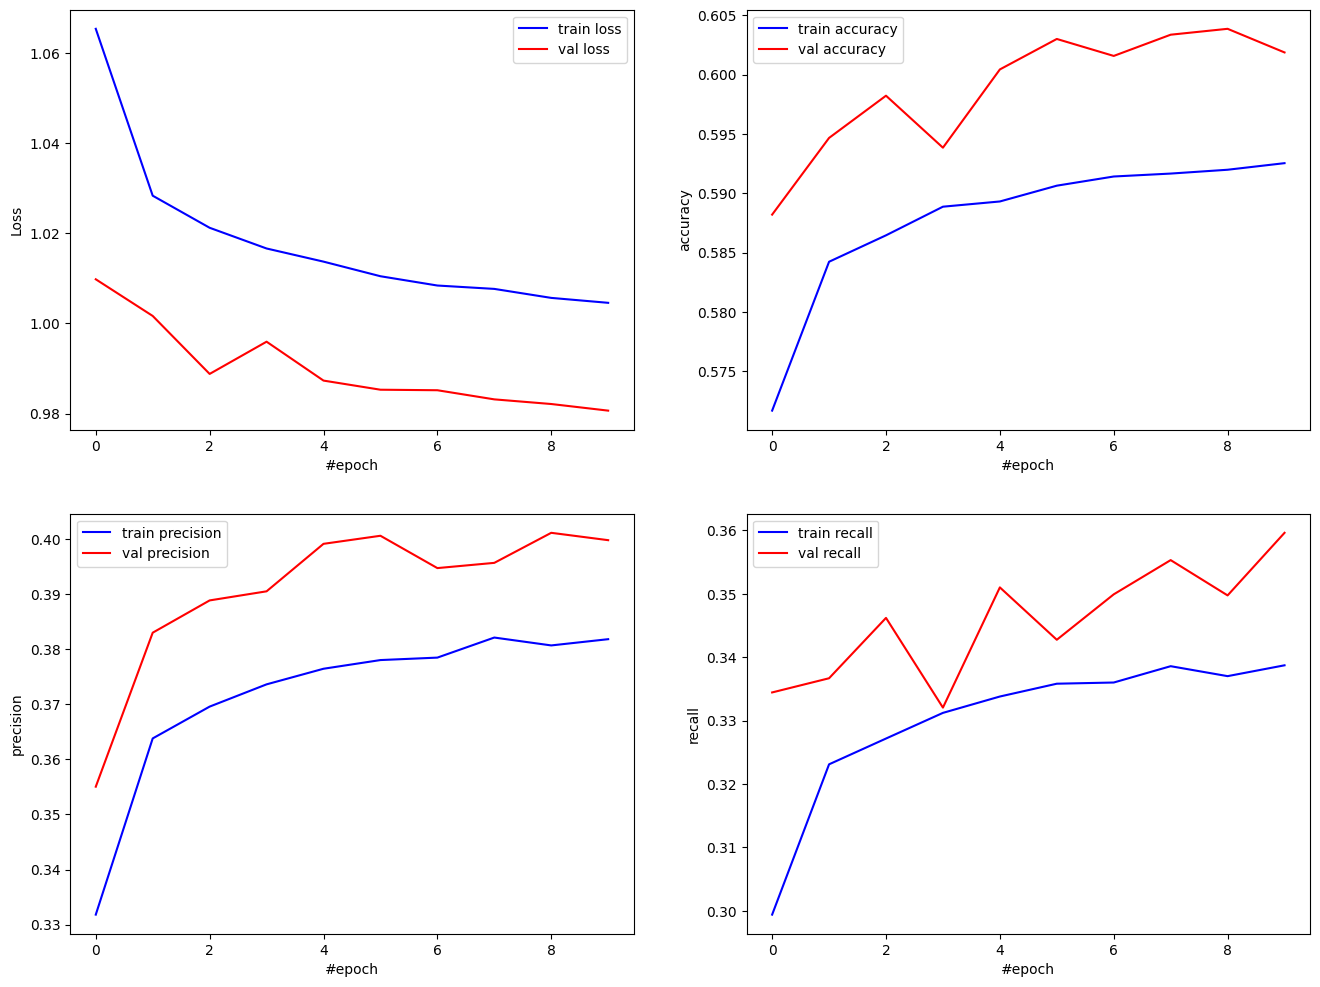

Final train metrics: {'accuracy': [0.5717013820432949, 0.5842391491857577, 0.586464206853042, 0.5888756974291235, 0.5893152256417334, 0.5906453314143764, 0.5914180483813729, 0.5916649210401798, 0.5919869583218328, 0.5925411433894563], 'precision': [0.3318196037648657, 0.3638114489307319, 0.36958758724491114, 0.3736277891750528, 0.37646081424520544, 0.37803747048348607, 0.3784830790493585, 0.3821252494038186, 0.38069539112506906, 0.3818283842013166], 'recall': [0.29941237552241773, 0.32311814735189376, 0.3271837346522609, 0.33123100342670747, 0.3338102444879673, 0.3358314159589261, 0.33601899343681696, 0.3385941160575506, 0.3370240631837633, 0.3387335340327869]}
Final test metrics: {'accuracy': [0.5882083063951296, 0.594666740746727, 0.5982225836431226, 0.5938451255320295, 0.6004340418080922, 0.6030007475351543, 0.6015713390981089, 0.603359362372717, 0.6038551936856851, 0.6018659757017403], 'precision': [0.35504820441020263, 0.38300696801432876, 0.3888667372592691, 0.3905185190508577, 0

classification mean train accuracy,▁▅▆▇▇▇████
classification mean train loss,█▄▃▂▂▂▁▁▁▁
classification mean train precision,▁▅▆▇▇▇▇███
classification mean train recall,▁▅▆▇▇▇████
classification mean val accuracy,▁▄▅▄▆█▇██▇
classification mean val loss,█▆▃▅▃▂▂▂▁▁
classification mean val precision,▁▅▆▆██▇▇██
classification mean val recall,▂▂▅▁▆▄▆▇▅█
classification mean train accuracy,0.59254
classification mean train loss,1.00459
classification mean train precision,0.38183


In [ ]:
set_random_seed(42)

model = AdvancedClassificationModel(output_shape=n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = torch.nn.CrossEntropyLoss()
metric_functions = {"accuracy": accuracy_score,
                    "precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro', zero_division=0),
                    "recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro', zero_division=0),}

wandb.init(project="ida-bodl-hw1", name="10_cl_classification_model_advanced")
wandb.watch(model);

train_loop_cl(model, train_dataloader_cl_10, test_dataloader_cl_10, optimizer, loss_function, metric_functions)

wandb.finish()

### 1 модель (каждый год - класс)
#### Final train accuracy: 0.0980921740073341
#### Final test accuracy: 0.08653140321103388
#### Final train recall: 0.06370981926593174
#### Final test recall: 0.055300701750887464
#### Final train precision: 0.05376355987587346
#### Final test precision: 0.04604678500941968

- nn.Linear(90, 64) -> nn.ReLU() -> nn.Linear(64, 1)
- lr = 1e-4

In [ ]:
set_random_seed(42)

X_train_cl, y_train_cl, X_test_cl, y_test_cl, n_classes = prepare_classification_data(df, binning=False)

scaler = StandardScaler()
X_train_cl_scaled = scaler.fit_transform(X_train_cl)
X_test_cl_scaled = scaler.transform(X_test_cl)

train_data_cl = CustomDataset(X_train_cl_scaled, y_train_cl)
test_data_cl = CustomDataset(X_test_cl_scaled, y_test_cl)

train_dataloader_cl = DataLoader(train_data_cl, batch_size=64, shuffle=True)
test_dataloader_cl = DataLoader(test_data_cl, batch_size=64, shuffle=True)

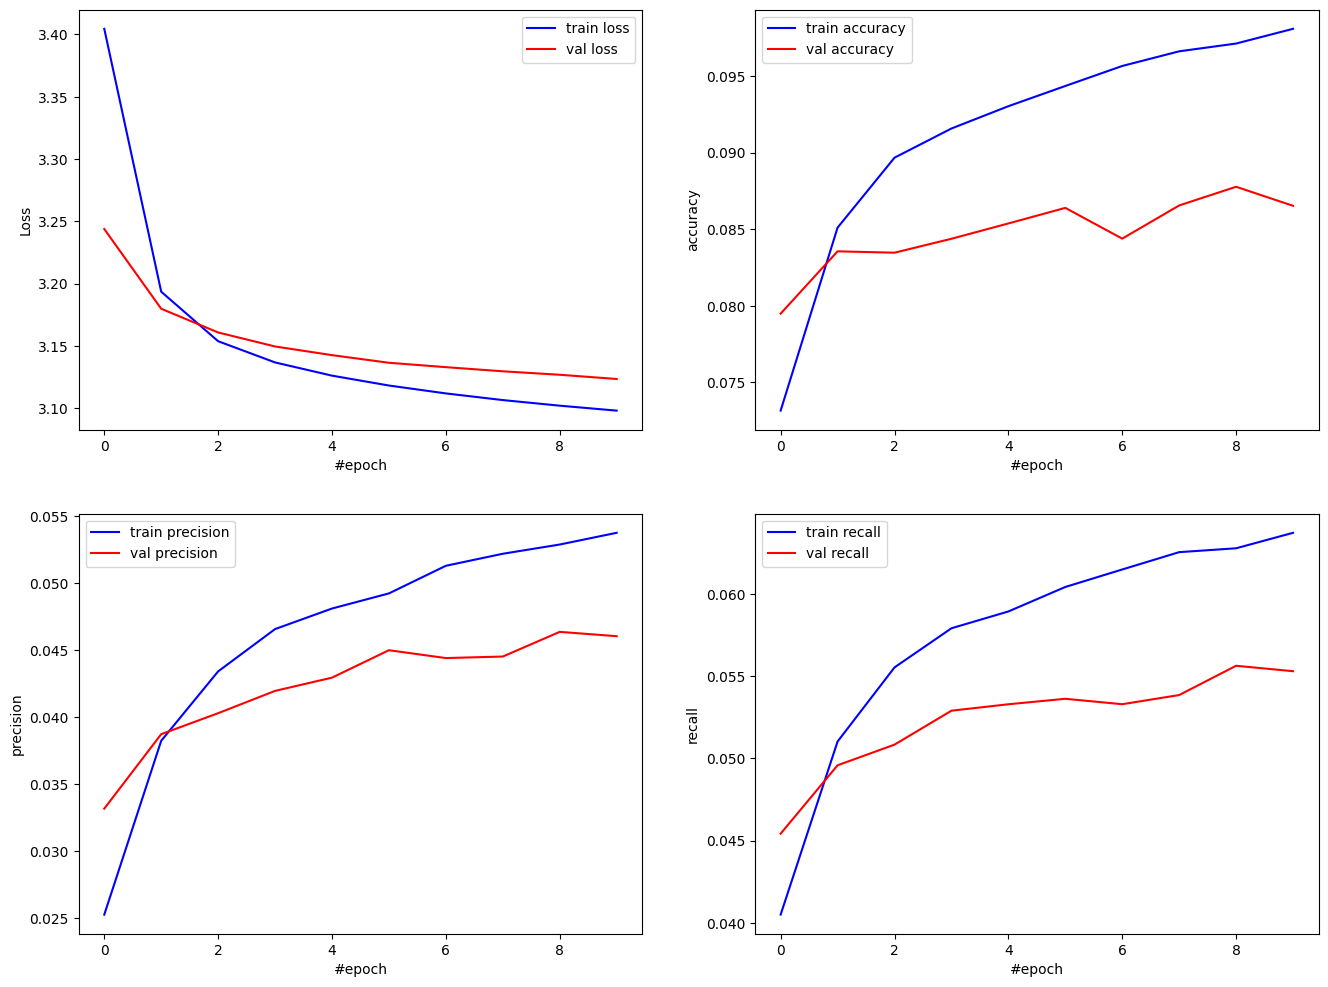

Final train metrics: {'accuracy': [0.07315095027798588, 0.08510477455541975, 0.08967410591065021, 0.0915795907101455, 0.09303655218642798, 0.094356615472576, 0.0956644182997516, 0.09662190469618706, 0.09712969717282441, 0.0980921740073341], 'precision': [0.025259820158518735, 0.03823710576121783, 0.04341887158290042, 0.04657669999668411, 0.04811118593476583, 0.04924000725252435, 0.05130233461705497, 0.05219951193667134, 0.05288935549008016, 0.05376355987587346], 'recall': [0.04050839295455506, 0.05102651300153948, 0.05553035279955733, 0.05790886461666528, 0.05893051918336473, 0.060417958238482075, 0.06148164899383407, 0.0625347210744663, 0.06276937979703369, 0.06370981926593174]}
Final test metrics: {'accuracy': [0.07948706292764397, 0.0835572571520931, 0.0834680243521362, 0.08437803054792306, 0.08537726954366683, 0.0863958703733635, 0.08438644873659824, 0.08655413232045686, 0.08777392785949031, 0.08653140321103388], 'precision': [0.03317278331073111, 0.03873229663282898, 0.04029759937

classification mean train accuracy,▁▄▆▆▇▇▇███
classification mean train loss,█▃▂▂▂▁▁▁▁▁
classification mean train precision,▁▄▅▆▇▇▇███
classification mean train recall,▁▄▆▆▇▇▇███
classification mean val accuracy,▁▄▄▅▆▇▅▇█▇
classification mean val loss,█▄▃▃▂▂▂▁▁▁
classification mean val precision,▁▄▅▆▆▇▇▇██
classification mean val recall,▁▄▅▆▆▇▆▇██
classification mean train accuracy,0.09809
classification mean train loss,3.09804
classification mean train precision,0.05376


In [ ]:
set_random_seed(42)

model = ClassificationModel(output_shape=n_classes, hidden_size=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.CrossEntropyLoss()
metric_functions = {"accuracy": accuracy_score,
                    "precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro', zero_division=0),
                    "recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro', zero_division=0),}

wandb.init(project="ida-bodl-hw1", name="all_cl_classification_model_pivot")
wandb.watch(model);

train_loop_cl(model, train_dataloader_cl, test_dataloader_cl, optimizer, loss_function, metric_functions)

wandb.finish()

### 2 модель (каждый год - класс)
#### Final train accuracy: 0.09398140846181144
#### Final test accuracy: 0.09505061015031517
#### Final train recall: 0.06046912522802164
#### Final test recall: 0.06254335208300164
#### Final train precision: 0.04790174849108725
#### Final test precision: 0.04917428188255267

- nn.Linear(90, 128) -> nn.BatchNorm1d(128) -> nn.Dropout(0.5) -> nn.ReLU() -> nn.Linear(128, 64) -> nn.BatchNorm1d(64) -> nn.ReLU() -> nn.Linear(64, 1)
- lr = 1e-3

In [ ]:
set_random_seed(42)

X_train_cl, y_train_cl, X_test_cl, y_test_cl, n_classes = prepare_classification_data(df, binning=False)

scaler = StandardScaler()
X_train_cl_scaled = scaler.fit_transform(X_train_cl)
X_test_cl_scaled = scaler.transform(X_test_cl)

train_data_cl = CustomDataset(X_train_cl_scaled, y_train_cl)
test_data_cl = CustomDataset(X_test_cl_scaled, y_test_cl)

train_dataloader_cl = DataLoader(train_data_cl, batch_size=64, shuffle=True)
test_dataloader_cl = DataLoader(test_data_cl, batch_size=64, shuffle=True)

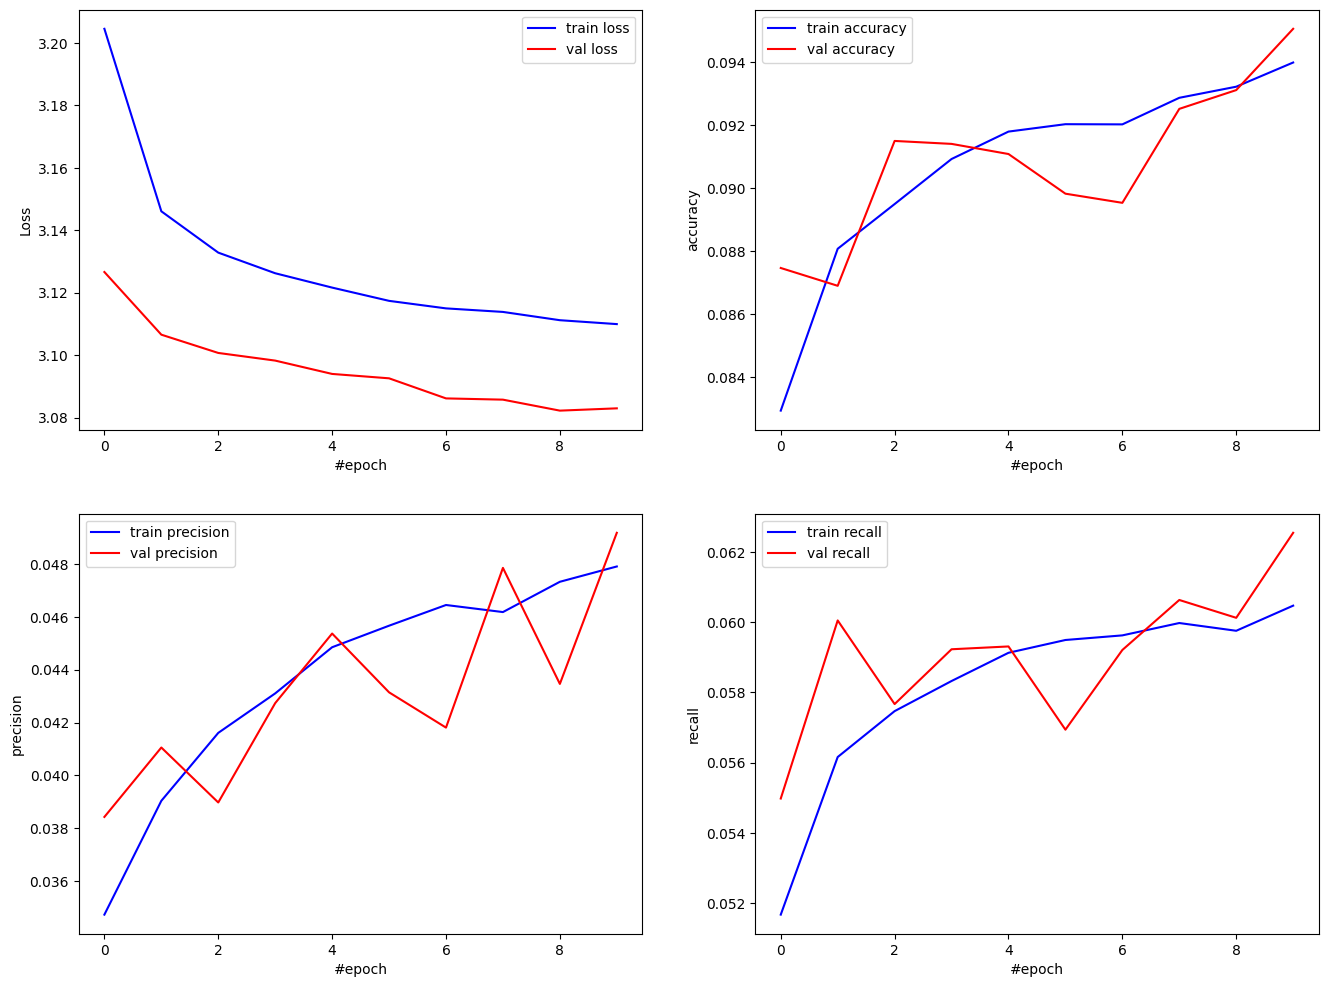

Final train metrics: {'accuracy': [0.08293399560348566, 0.08807045019912464, 0.08948933648121131, 0.09091937423603169, 0.09178912749891566, 0.09202380130909664, 0.09201800993651671, 0.09286120914001815, 0.09321374354323567, 0.09398140846181144], 'precision': [0.0347402598376719, 0.03904239557319077, 0.04161090378694236, 0.043103479735398596, 0.04484857919223548, 0.04566273170638233, 0.046445397751559384, 0.04617801361949305, 0.04732305437682884, 0.04790174849108725], 'recall': [0.05167019303247875, 0.056158294661854416, 0.057465576712040514, 0.05832307343246162, 0.05912669145794418, 0.0594911664277922, 0.05962234875416034, 0.059974301313289693, 0.05975364623597066, 0.06046912522802164]}
Final test metrics: {'accuracy': [0.08746077124077366, 0.08689506896180162, 0.09149224179731695, 0.09139879990302247, 0.09107722509563061, 0.08981870588869133, 0.08952827837939765, 0.0925100008081461, 0.09310600856634879, 0.09505061015031517], 'precision': [0.038433597468180224, 0.04105760036100923, 0.0

classification mean train accuracy,▁▄▅▆▇▇▇▇██
classification mean train loss,█▄▃▂▂▂▁▁▁▁
classification mean train precision,▁▃▅▅▆▇▇▇██
classification mean train recall,▁▅▆▆▇▇▇█▇█
classification mean val accuracy,▁▁▅▅▅▄▃▆▆█
classification mean val loss,█▅▄▄▃▃▂▂▁▁
classification mean val precision,▁▃▁▄▆▄▃▇▄█
classification mean val recall,▁▆▃▅▅▃▅▆▆█
classification mean train accuracy,0.09398
classification mean train loss,3.10994
classification mean train precision,0.0479


In [ ]:
set_random_seed(42)

model = AdvancedClassificationModel(output_shape=n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = torch.nn.CrossEntropyLoss()
metric_functions = {"accuracy": accuracy_score,
                    "precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro', zero_division=0),
                    "recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro', zero_division=0),}

wandb.init(project="ida-bodl-hw1", name="all_cl_classification_model_advanced")
wandb.watch(model);

train_loop_cl(model, train_dataloader_cl, test_dataloader_cl, optimizer, loss_function, metric_functions)

wandb.finish()

## To sum up

Ну, очевидно мы видим, что с задачей классификацией моделька справляется сильно хуже. Для 10 классов результаты еще более или менее, но для ситуации, где каждый год - класс, все совсем плохо.

На самом деле, это достаточно легко объяснимо:
предположим, что правильный ответ - *X*, а модель ответила *X+1* (ну или в случае классификации подумала, что правильный класс - тот, что включает *X+1*). Если мы решаем задачу регрессии, результат будет отличный, ведь ошибка очень маленькая. Если мы решаем задачу классификации на 10 классов, то успех примерно 50/50 - *X* и *X+1* либо в одном классе, либо в соседних. Если мы решаем задачу классификации, где каждый год - класс, то мы точно получим нвеерный ответ, и не важно, ответила модель *X+1* или *X+100*.

А еще судя по графикам, на классификации, где каждый год - класс, мы переобучаемся довольно сильно - опять же, ровно по причинам выше. В этой задаче классификация - просто неправильный подход, так как мы говорим не о категорически отличающихся классах, а о чем-то, что плавно перетакет из одного в другое.

На обеих классификациях запускались самая простая и самая сложная модели из предыдущего задания.

# ВСЕ

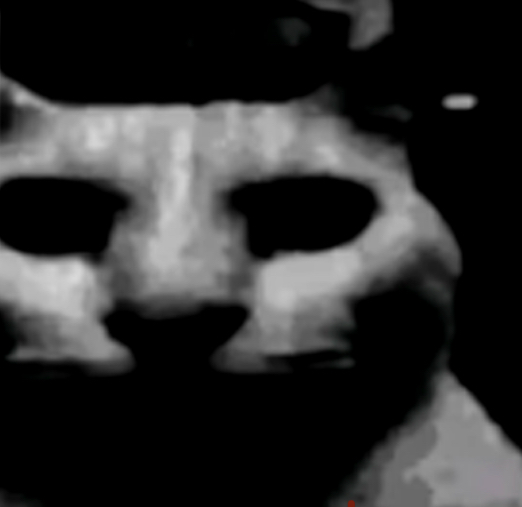